In [99]:
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [94]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import datetime

from sklearn import preprocessing
from sklearn import metrics
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import plot_partial_dependence
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras import regularizers
import tensorflow.keras as keras
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers

# Data wrangling

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('Wildfire.csv')
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'fire_name','disc_date_final','cont_date_final','cont_clean_date','putout_time'])
df['disc_clean_date'] = pd.to_datetime(df['disc_clean_date'], format='%m/%d/%Y')
df.columns

Index(['fire_size', 'fire_size_class', 'stat_cause_descr', 'latitude',
       'longitude', 'state', 'disc_clean_date', 'discovery_month',
       'disc_date_pre', 'disc_pre_year', 'disc_pre_month', 'wstation_usaf',
       'dstation_m', 'wstation_wban', 'wstation_byear', 'wstation_eyear',
       'Vegetation', 'fire_mag', 'weather_file', 'Temp_pre_30', 'Temp_pre_15',
       'Temp_pre_7', 'Temp_cont', 'Wind_pre_30', 'Wind_pre_15', 'Wind_pre_7',
       'Wind_cont', 'Hum_pre_30', 'Hum_pre_15', 'Hum_pre_7', 'Hum_cont',
       'Prec_pre_30', 'Prec_pre_15', 'Prec_pre_7', 'Prec_cont', 'remoteness'],
      dtype='object')

In [4]:
#one hot encoding vegetation
df['Vegetation'] = df['Vegetation'].astype('category')
df['Cause'] = df['stat_cause_descr'].astype('category')

df = pd.get_dummies(df,prefix=['Vegetation'], columns = ['Vegetation'], drop_first=True)
df = pd.get_dummies(df,prefix=['Cause'], columns = ['stat_cause_descr'], drop_first=True)

df.head()

,fire_size,fire_size_class,latitude,longitude,state,disc_clean_date,discovery_month,disc_date_pre,disc_pre_year,disc_pre_month,wstation_usaf,dstation_m,wstation_wban,wstation_byear,wstation_eyear,fire_mag,weather_file,Temp_pre_30,Temp_pre_15,Temp_pre_7,Temp_cont,Wind_pre_30,Wind_pre_15,Wind_pre_7,Wind_cont,Hum_pre_30,Hum_pre_15,Hum_pre_7,Hum_cont,Prec_pre_30,Prec_pre_15,Prec_pre_7,Prec_cont,remoteness,Cause,Vegetation_4,Vegetation_9,Vegetation_12,Vegetation_14,Vegetation_15,Vegetation_16,Cause_Campfire,Cause_Children,Cause_Debris Burning,Cause_Equipment Use,Cause_Fireworks,Cause_Lightning,Cause_Miscellaneous,Cause_Missing/Undefined,Cause_Powerline,Cause_Railroad,Cause_Smoking,Cause_Structure
0,10.0,C,18.105072,-66.753044,PR,2007-02-11,Feb,1/12/2007,2007,Jan,785140,58917.69716,11603,1945,2018,1.0,785140-11603-2007.gz,24.480974,24.716923,24.902597,24.527961,4.341807,3.492857,3.262092,3.250413,78.216590,76.793750,76.381579,78.724370,0.0,0.0,0.0,0.0,0.017923,Missing/Undefined,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,3.0,B,35.038330,-87.610000,TN,2006-12-11,Dec,11/11/2006,2006,Nov,723235,32665.34327,13896,1978,2020,0.1,723235-13896-2006.gz,7.553433,7.010000,0.343529,10.448298,2.709764,2.881707,1.976471,2.122320,70.840000,65.858911,55.505882,81.682678,59.8,8.4,0.0,86.8,0.184355,Arson,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,60.0,C,34.947800,-88.722500,MS,2004-02-29,Feb,1/30/2004,2004,Jan,723235,105122.14950,13896,1978,2020,1.0,723235-13896-2004.gz,4.971930,5.782766,5.558750,13.696600,3.364499,2.923830,2.695833,3.369050,75.531629,75.868613,76.812834,65.063800,168.8,42.2,18.1,124.5,0.194544,Arson,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,B,39.641400,-119.308300,NV,2005-06-06,Jun,5/7/2005,2005,May,724880,43433.32978,23185,1942,2020,0.1,724880-23185-2005.gz,16.275967,18.996181,18.142564,0.000000,4.054982,3.398329,3.671282,0.000000,44.778429,37.140811,35.353846,0.000000,10.4,7.2,0.0,0.0,0.487447,Debris Burning,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2.0,B,30.700600,-90.591400,LA,1999-09-22,Sep,8/23/1999,1999,Aug,722312,25940.57409,3908,1987,2016,0.1,File Not Found,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.214633,Miscellaneous,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


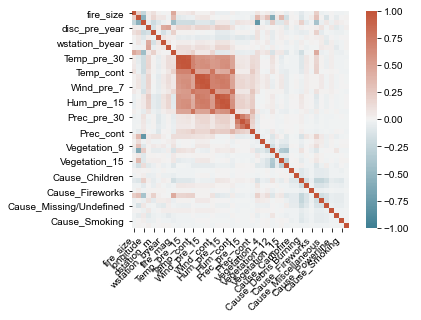

In [5]:
df_numerics_only = df.select_dtypes(include=np.number)

corr = df_numerics_only.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
sns.set(rc={'figure.figsize':(15,16)})

In [6]:
### Dealing with missing data
print(len(df))

# drop columns where weather file is missing
index = df[df['weather_file'] == 'File Not Found'].index
df.drop(index, inplace = True)
print(len(df))

# Weather data has a lot of 0 values some of which may be missing values
# So here we mark '0' values in weather columns as Na (to see how many there are)
subset = ['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont']
df[subset] = df[subset].replace({0:np.nan, '0':np.nan})

# Mark -1 as missing
subset_neg1 = ['Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont']
df[subset_neg1] = df[subset_neg1].replace({-1:np.nan})

# Drop observations where all weather columns are 0
df = df.dropna(how='all',
                    subset=['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont'])
print(len(df))
# This leaves us with 38,689 observations to work with (originally we had 50,000)

# fill the 'pre' columns temp wind and humidity with mean values
subset_fill_mean = ['Temp_pre_30','Temp_pre_15','Temp_pre_7', 'Wind_pre_30','Wind_pre_15','Wind_pre_7', 'Hum_pre_30', 'Hum_pre_15','Hum_pre_7']
df[subset_fill_mean] = df[subset_fill_mean].fillna(df[subset_fill_mean].mean())

# Fill current NAs based on mean values from previous days
df['Temp_cont'] = df.apply(
    lambda row: (row['Temp_pre_7']+row['Temp_pre_15']+row['Temp_pre_30'])/3 if np.isnan(row['Temp_cont']) else row['Temp_cont'],
    axis=1)

df['Wind_cont'] = df.apply(
    lambda row: (row['Wind_pre_7']+row['Wind_pre_15']+row['Wind_pre_30'])/3 if np.isnan(row['Wind_cont']) else row['Wind_cont'],
    axis=1)

df['Hum_cont'] = df.apply(
    lambda row: (row['Hum_pre_7']+row['Hum_pre_15']+row['Hum_pre_30'])/3 if np.isnan(row['Hum_cont']) else row['Hum_cont'],
    axis=1)

55367
41132
38689


In [7]:
# selecting features and target variables
X = df[['Vegetation_4','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Debris Burning','Cause_Equipment Use','Cause_Fireworks','Cause_Lightning','Cause_Miscellaneous','Cause_Missing/Undefined','Cause_Powerline','Cause_Railroad','Cause_Smoking','Cause_Structure', 'longitude']]
y = df['fire_size'] + df['fire_mag']

X_norm = (X-X.min())/(X.max()-X.min())
y_norm = (y-y.min())/(y.max()-y.min())

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
sns.pairplot(X_train[['latitude', 'Hum_cont', 'Temp_pre_15', 'Temp_cont']], diag_kind='kde')

## Modelling
### Decision trees

In [102]:
# Deccision trees
dectr = DecisionTreeRegressor(random_state=0)
dectr.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [103]:
predictions = dectr.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('R Squared:', metrics.r2_score(y_test, predictions))

Mean Absolute Error: 3412.9348744055314
R Squared: -0.5227685592697597


### Gradient Boosting

In [105]:
gr_boost = GradientBoostingRegressor()
gr_boost.fit(X_train, y_train)

GradientBoostingRegressor()

In [106]:
predictions = gr_boost.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('R Squared:', metrics.r2_score(y_test, predictions))

Mean Absolute Error: 3073.8280814305567
R Squared: 0.06570787031136271


### XGBoost

In [107]:
XGBModel = XGBRegressor(n_estimators=10)
XGBModel.fit(X_train, y_train, verbose=True)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(X_test)
MAE = metrics.mean_absolute_error(y_test , XGBpredictions)
print('XGBoost validation MAE = ',MAE)
print('R Squared:', metrics.r2_score(y_test, XGBpredictions))

XGBoost validation MAE =  2946.564253518771
R Squared: 0.1047734092282111


### Random Forest

In [112]:
# Random Forest Regressor 
rf_reg = RandomForestRegressor(n_estimators = 250, max_depth=10)

# fit the regressor with x and y data
rf_reg.fit(X_train, y_train)  

RandomForestRegressor(max_depth=10, n_estimators=250)

In [113]:
predictions = rf_reg.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('R Squared:', metrics.r2_score(y_test, predictions))

Mean Absolute Error: 2931.0582888578124
R Squared: 0.1393975733905196


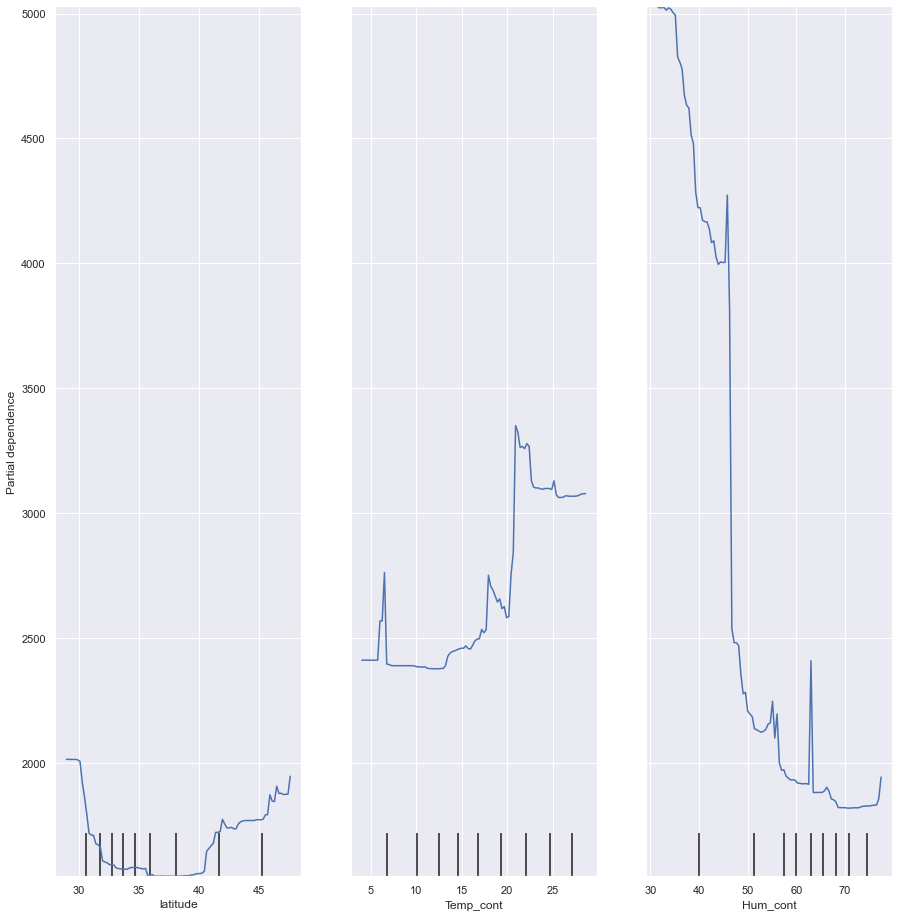

In [110]:
features = [6, 10, 18]
plot_partial_dependence(rf_reg, X, features)

### Hyper-parameter tuning
Performing Grid Search
Testing the model with different values for parameters like the number of estimators and maximum depth, and then selects the parametres that produce the best results.

The basemodel of Random Forest Regressor produced the best results, so that is the algorithm we will tune.

In [116]:
# Shwo which parameters can be tuned and score measures

#rf_reg.get_params().keys()
#sklearn.metrics.SCORERS.keys()

In [111]:
search_grid={'n_estimators':[50,100,200],'max_depth':[2,4,6,8,10]}
search=GridSearchCV(estimator=rf_reg,param_grid=search_grid,scoring='neg_mean_absolute_error',n_jobs=1,cv=5, verbose=10)
search.fit(X_train, y_train)
print(search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START max_depth=2, n_estimators=50...............................
[CV 1/5; 1/15] END .............max_depth=2, n_estimators=50; total time=   2.6s
[CV 2/5; 1/15] START max_depth=2, n_estimators=50...............................
[CV 2/5; 1/15] END .............max_depth=2, n_estimators=50; total time=   2.5s
[CV 3/5; 1/15] START max_depth=2, n_estimators=50...............................
[CV 3/5; 1/15] END .............max_depth=2, n_estimators=50; total time=   2.6s
[CV 4/5; 1/15] START max_depth=2, n_estimators=50...............................
[CV 4/5; 1/15] END .............max_depth=2, n_estimators=50; total time=   2.5s
[CV 5/5; 1/15] START max_depth=2, n_estimators=50...............................
[CV 5/5; 1/15] END .............max_depth=2, n_estimators=50; total time=   2.4s
[CV 1/5; 2/15] START max_depth=2, n_estimators=100..............................
[CV 1/5; 2/15] END ............max_depth=2, n_es

[CV 1/5; 11/15] END ...........max_depth=8, n_estimators=100; total time=  22.7s
[CV 2/5; 11/15] START max_depth=8, n_estimators=100.............................
[CV 2/5; 11/15] END ...........max_depth=8, n_estimators=100; total time=  20.5s
[CV 3/5; 11/15] START max_depth=8, n_estimators=100.............................
[CV 3/5; 11/15] END ...........max_depth=8, n_estimators=100; total time=  19.7s
[CV 4/5; 11/15] START max_depth=8, n_estimators=100.............................
[CV 4/5; 11/15] END ...........max_depth=8, n_estimators=100; total time=  20.2s
[CV 5/5; 11/15] START max_depth=8, n_estimators=100.............................
[CV 5/5; 11/15] END ...........max_depth=8, n_estimators=100; total time=  19.3s
[CV 1/5; 12/15] START max_depth=8, n_estimators=200.............................
[CV 1/5; 12/15] END ...........max_depth=8, n_estimators=200; total time=  43.8s
[CV 2/5; 12/15] START max_depth=8, n_estimators=200.............................
[CV 2/5; 12/15] END ........

### Fetaure Importance
What features are the most influential in the model?

In [95]:
feature_importances = pd.DataFrame(rf_reg.feature_importances_,
    index = X_train.columns,columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
latitude,1.979472e-01
longitude,1.043419e-01
Hum_cont,1.035047e-01
Temp_cont,7.773041e-02
Hum_pre_30,6.146159e-02
Wind_pre_7,6.058846e-02
Wind_pre_30,4.805534e-02
Temp_pre_30,4.524614e-02
Hum_pre_7,4.275188e-02
Temp_pre_15,4.259794e-02


Reevaluate model after deleting least important features

In [114]:
# selecting features and target variables
X2 = df[['Vegetation_9','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Lightning', 'longitude']]
y2 = y

X_norm = (X-X.min())/(X.max()-X.min())
y_norm = (y-y.min())/(y.max()-y.min())

#train test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [117]:
# Random Forest Regressor 
rf_reg = RandomForestRegressor(n_estimators = 200, max_depth=10)

# fit the regressor with x and y data
rf_reg.fit(X2_train, y2_train)

predictions = rf_reg.predict(X2_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y2_test, predictions))
print('R Squared:', metrics.r2_score(y2_test, predictions))

Mean Absolute Error: 2943.424693693293
R Squared: 0.14449143867407133


### Neural network model

In [26]:
X_train.shape

(30951, 34)

In [27]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

In [74]:
model = Sequential([
    normalizer,
    Dense(21, activation="relu", kernel_initializer='normal',input_dim = X_train.shape[1]),
    Dense(20, activation="relu"),
    Dense(15, activation="relu", ),
    Dense(1, activation='linear')
])

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy','mae']
)

#kernel_regularizer = regularizers.l2(1e-5)
#checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
#checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')

In [75]:
history = model.fit(
    X_train,
    y_train,
    epochs=200,
    validation_split=0.15,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_mae',
        patience=30,
        mode='min',
        restore_best_weights=True
    )]
)


Epoch 1/200
823/823 [==============================] - 1s 1ms/step - loss: 226401872.0000 - accuracy: 0.0025 - mae: 2544.3872 - val_loss: 216905712.0000 - val_accuracy: 0.0017 - val_mae: 3289.9146
Epoch 2/200
823/823 [==============================] - 1s 1ms/step - loss: 211633776.0000 - accuracy: 0.0027 - mae: 3246.9397 - val_loss: 212129296.0000 - val_accuracy: 0.0017 - val_mae: 3676.4468
Epoch 3/200
823/823 [==============================] - 1s 1ms/step - loss: 209084784.0000 - accuracy: 0.0027 - mae: 3362.1340 - val_loss: 211198592.0000 - val_accuracy: 0.0017 - val_mae: 3499.9712
Epoch 4/200
823/823 [==============================] - 1s 1ms/step - loss: 207449216.0000 - accuracy: 0.0027 - mae: 3255.7478 - val_loss: 210532288.0000 - val_accuracy: 0.0017 - val_mae: 3458.2920
Epoch 5/200
823/823 [==============================] - 1s 1ms/step - loss: 206362048.0000 - accuracy: 0.0027 - mae: 3228.5723 - val_loss: 209768640.0000 - val_accuracy: 0.0017 - val_mae: 3449.1250
Epoch 6/200
823

823/823 [==============================] - 1s 1ms/step - loss: 200727648.0000 - accuracy: 8.7426e-04 - mae: 2889.3110 - val_loss: 207681824.0000 - val_accuracy: 2.1538e-04 - val_mae: 3046.6646
Epoch 42/200
823/823 [==============================] - 1s 1ms/step - loss: 200597856.0000 - accuracy: 8.3625e-04 - mae: 2867.5925 - val_loss: 207610768.0000 - val_accuracy: 2.1538e-04 - val_mae: 3048.0518
Epoch 43/200
823/823 [==============================] - 1s 1ms/step - loss: 200511760.0000 - accuracy: 7.6023e-04 - mae: 2853.9006 - val_loss: 207394832.0000 - val_accuracy: 2.1538e-04 - val_mae: 3096.4670
Epoch 44/200
823/823 [==============================] - 1s 1ms/step - loss: 200425216.0000 - accuracy: 8.3625e-04 - mae: 2872.6331 - val_loss: 207376496.0000 - val_accuracy: 2.1538e-04 - val_mae: 3133.8853
Epoch 45/200
823/823 [==============================] - 1s 1ms/step - loss: 200461056.0000 - accuracy: 8.3625e-04 - mae: 2872.3562 - val_loss: 207575744.0000 - val_accuracy: 2.1538e-04 - va

823/823 [==============================] - 1s 1ms/step - loss: 198869088.0000 - accuracy: 0.0027 - mae: 2809.5439 - val_loss: 206791824.0000 - val_accuracy: 0.0017 - val_mae: 3045.1672
Epoch 81/200
823/823 [==============================] - 1s 1ms/step - loss: 198765232.0000 - accuracy: 0.0027 - mae: 2813.2944 - val_loss: 206972384.0000 - val_accuracy: 0.0017 - val_mae: 3017.2324
Epoch 82/200
823/823 [==============================] - 1s 1ms/step - loss: 198776832.0000 - accuracy: 0.0027 - mae: 2799.9438 - val_loss: 206654432.0000 - val_accuracy: 0.0017 - val_mae: 3095.7212
Epoch 83/200
823/823 [==============================] - 1s 1ms/step - loss: 198624096.0000 - accuracy: 0.0027 - mae: 2816.1125 - val_loss: 207010912.0000 - val_accuracy: 0.0017 - val_mae: 3084.1724
Epoch 84/200
823/823 [==============================] - 1s 1ms/step - loss: 198756432.0000 - accuracy: 0.0027 - mae: 2844.8193 - val_loss: 207111120.0000 - val_accuracy: 0.0017 - val_mae: 2936.4412
Epoch 85/200
823/823 [=

823/823 [==============================] - 1s 1ms/step - loss: 197385520.0000 - accuracy: 0.0027 - mae: 2756.0840 - val_loss: 206599952.0000 - val_accuracy: 0.0017 - val_mae: 2988.9297
Epoch 122/200
823/823 [==============================] - 1s 2ms/step - loss: 197311168.0000 - accuracy: 0.0027 - mae: 2801.8398 - val_loss: 206534848.0000 - val_accuracy: 0.0017 - val_mae: 2954.6262
Epoch 123/200
823/823 [==============================] - 1s 1ms/step - loss: 197328256.0000 - accuracy: 0.0027 - mae: 2781.6252 - val_loss: 206475184.0000 - val_accuracy: 0.0017 - val_mae: 2998.9084
Epoch 124/200
823/823 [==============================] - 1s 1ms/step - loss: 197229216.0000 - accuracy: 0.0027 - mae: 2763.4727 - val_loss: 206485456.0000 - val_accuracy: 0.0017 - val_mae: 3084.1921
Epoch 125/200
823/823 [==============================] - 1s 1ms/step - loss: 196801616.0000 - accuracy: 0.0027 - mae: 2832.2961 - val_loss: 206928064.0000 - val_accuracy: 0.0017 - val_mae: 2844.9143
Epoch 126/200
823/8

In [81]:
test_loss, test_acc, test_mae = model.evaluate(x=X_test, y=y_test, verbose=0)
print('Mean Absolute Error: {acc:0.3f}'.format(acc=test_mae))
print('accuracy: {acc:0.3f}'.format(acc=test_acc))
print('loss: {acc:0.3f}'.format(acc=test_loss))

Mean Absolute Error: 2707.866
accuracy: 0.002
loss: 211382272.000


In [77]:
historydf = pd.DataFrame(history.history)

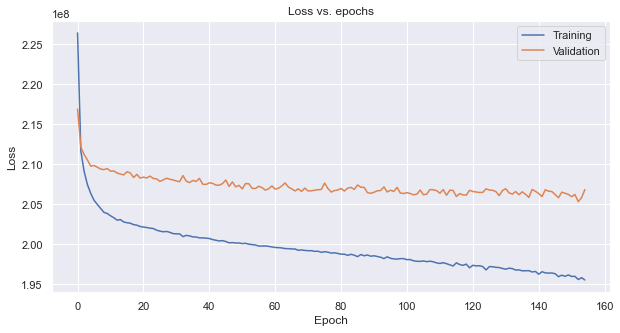

In [78]:
#Run this cell to plot the epoch vs loss graph
plt.figure(figsize=(10, 5))
plt.plot(historydf['loss'])
plt.plot(historydf['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

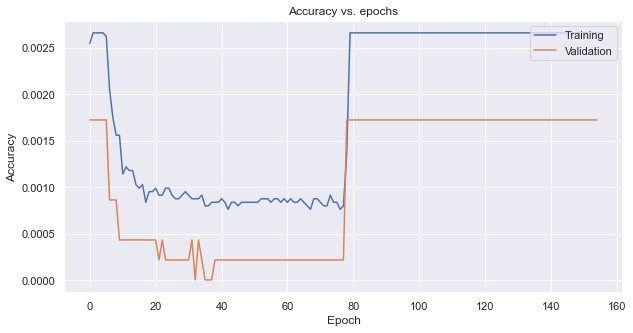

In [79]:
#Run this cell to plot the epoch vs loss graph
plt.figure(figsize=(10, 5))
plt.plot(historydf['accuracy'],label='accuracy')
plt.plot(historydf['val_accuracy'],label='val_accuracy')
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

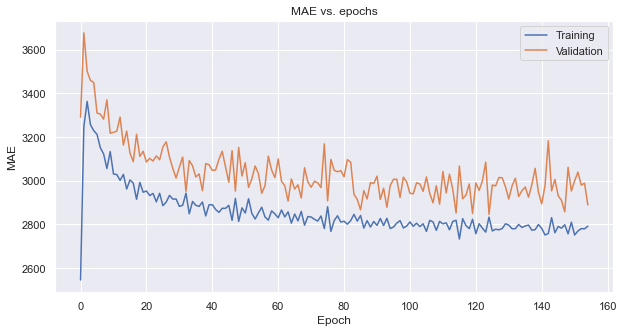

In [80]:
#Run this cell to plot the epoch vs loss graph
plt.figure(figsize=(10, 5))
plt.plot(historydf['mae'],label='mae')
plt.plot(historydf['val_mae'],label='val_mae')
plt.title('MAE vs. epochs')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

## Other

In [ ]:
#XGBModel.get_params().keys()

#search_grid={'n_estimators':[10,50,100,250]}
#searchxgb=GridSearchCV(estimator=XGBModel,param_grid=search_grid,scoring='r2',n_jobs=1,cv=3)
#searchxgb.fit(X_train, y_train)
#print(searchxgb.best_score_)
#print(searchxgb.best_params_)

In [ ]:
#PCA Analysis
X_scaled = StandardScaler().fit_transform(X_train)

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2','pc3','pc4','pc5'])

X_pcca = principalDf[['pc1','pc2','pc3','pc4','pc5']]

In [ ]:
# Get weather stations ordered by distance to Vancouver, BC
stations = Stations(lat = 38.843988, lon = -122.759707, daily = datetime(2018, 1, 1))
# Fetch closest station (limit = 1)
station = stations.fetch(1)

data = Daily(station, start = datetime(2018, 1, 1), end = datetime(2018, 1, 1))
# Fetch Pandas DataFrame
data = data.fetch()

data.plot(y=['tavg', 'tmin', 'tmax'])